# Проект "Маркетинг"
## Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.
## Цель
Предсказать вероятность покупки в течение 90 дней
## Задачи
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

## Описание данных
### apparel-purchases
история покупок
- client_id -- идентификатор пользователя
- quantity -- количество товаров в заказе
- price -- цена товара
- category_ids -- вложенные категории, к которым относится товар
- date -- дата покупки
- message_id -- идентификатор сообщения из рассылки
### apparel-messages
история рекламных рассылок
- bulk_campaign_id -- идентификатор рекламной кампании
- client_id -- идентификатор пользователя
- message_id -- идентификатор сообщений
- event -- тип действия
- channel -- канал рассылки
- date -- дата рассылки
- created_at -- точное время создания сообщения
### apparel-target_binary
совершит ли клиент покупку в течение следующих 90 дней
- client_id -- идентификатор пользователя
- target -- целевой признак

## Загрузка зависимостей

In [1]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Изучение данных

In [4]:
# функция для вывода информации о данных
def df_info(df, df_name):
    print("-" * 60)
    # вывод информации о датасете
    print('\033[1m' + f'Информация о датафрейме {df_name}:' + '\033[0m')
    df.info()
    print("=" * 60)
    # вывод 5 первых строк из датасета
    print('\033[1m' + f'Первые строки датафрейма {df_name}:' + '\033[0m')
    display(df.head())
    print("-" * 60)

### Загрузка данных

In [5]:
# загрузка таблиц с входными признаками
purchases = pd.read_csv("apparel-purchases.csv")
messages = pd.read_csv("apparel-messages.csv")

In [6]:
# загрузка таблицы с целевым признаком
target_binary = pd.read_csv("apparel-target_binary.csv")

In [7]:
# вывод информации о данных
for df, df_name in [(purchases, 'purchases'),
                    (messages, 'messages'),
                    (target_binary, 'target')]:
    df_info(df, df_name)

------------------------------------------------------------
Информация о датафрейме purchases:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
Первые строки датафрейма purchases:


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


------------------------------------------------------------
------------------------------------------------------------
Информация о датафрейме messages:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
Первые строки датафрейма messages:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


------------------------------------------------------------
------------------------------------------------------------
Информация о датафрейме target:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
Первые строки датафрейма target:


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


------------------------------------------------------------


Дополнительно подсчитаем пропуски в messages:

In [8]:
# подсчет пропусков
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

- В данных нет пропусков
- Необходимо изменить тип данных цены на int, а дат на datetime

#### Замена типов данных

In [9]:
# замена типов данных в purchases
purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')
purchases['price'] = purchases['price'].astype('int64')

In [10]:
# вывод типов данных в purchases
print("Типы данных в purchases заменены:")
purchases.dtypes

Типы данных в purchases заменены:


client_id                int64
quantity                 int64
price                    int64
category_ids            object
date            datetime64[ns]
message_id              object
dtype: object

In [11]:
# замена типов данных в messages
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')

In [12]:
# вывод типов данных в messages
print("Типы данных в messages заменены:")
messages.dtypes

Типы данных в messages заменены:


bulk_campaign_id             int64
client_id                    int64
message_id                  object
event                       object
channel                     object
date                datetime64[ns]
created_at          datetime64[ns]
dtype: object

## Разработка признаков
Нам доступны сырые данные о покупках каждого клиента и рассылках, полученных ими. Чтобы делать предсказания о том, кто из клиентов совершит покупку в целевом периоде, необходимо создать признаки на основе агрегированных данных, где каждому клиенту будет соответствовать одна строка.

In [13]:
print('Количество client_id в purchases:', purchases['client_id'].nunique())
print('Количество client_id в messages:', messages['client_id'].nunique())
print('Количество client_id в target_binary:', target_binary['client_id'].nunique())

Количество client_id в purchases: 49849
Количество client_id в messages: 53329
Количество client_id в target_binary: 49849


In [14]:
print('Количество совпадающих id в purchases и messages:', len(set(purchases['client_id']).intersection(set(messages['client_id']))))
print('Количество совпадающих id в purchases и target_binary:', len(set(purchases['client_id']).intersection(set(target_binary['client_id']))))
print('Количество совпадающих id в messages и target_binary:', len(set(messages['client_id']).intersection(set(target_binary['client_id']))))

Количество совпадающих id в purchases и messages: 41982
Количество совпадающих id в purchases и target_binary: 49849
Количество совпадающих id в messages и target_binary: 41982


Данные о покупках доступны для всех клиентов, в то время как данные о рассылках доступны не для всех. Проверим, всем ли клиентам приходили сообщения, на основании message_id из purchases:

In [15]:
print('Подсчет сообщений в purchases по клиентам:')
purchases.groupby('client_id')['message_id'].count().sort_values()

Подсчет сообщений в purchases по клиентам:


client_id
1515915626010443624      1
1515915625489760880      1
1515915625555455526      1
1515915625489761210      1
1515915625555449941      1
                      ... 
1515915625500232103    131
1515915625470860261    131
1515915625607113301    210
1515915625624308268    218
1515915625853312319    346
Name: message_id, Length: 49849, dtype: int64

Минимальное количество сообщений -- 1. То есть, все клиенты так или иначе получали рассылки, но не для всех доступны данные о них.

### На основе purchases
Произведем агрегацию данных по client_id и создадим признаки:
- days_since_last_purchase -- сколько дней прошло с последней покупки
- orders_count -- количество заказов
- sum_spent -- общая сумма всех покупок клиента
- items_count -- общее количество купленных товаров
- avg_check -- средняя сумма заказа
- avg_item_price -- средняя цена товара
- max_item_price -- максимальная цена товара
- items_per_order -- среднее количество товаров в заказе
- favorite_category -- наиболее частая корневая категория товаров

In [16]:
# точка отсчета для определения давности покупки
date = purchases['date'].max() + pd.Timedelta(days=1)

In [17]:
# агрегируем по клиентам
purchases_agg = purchases.groupby('client_id').agg({
    # сколько дней прошло с последней покупки и количество уникальных заказов
    'date': [lambda x: (date - x.max()).days, 'nunique'],
    # общая сумма всех покупок клиента, средняя и максимальная цена товара
    'price': [lambda x: (x * purchases.loc[x.index, 'quantity']).sum(), 'mean', 'max'],
    # общее количество купленных товаров
    'quantity': 'sum'
})

# переименование колонок
purchases_agg.columns = ['days_since_last_purchase',
                         'orders_count',
                         'sum_spent',
                         'avg_item_price',
                         'max_item_price',
                         'items_count'
]

# вывод агрегированных данных
purchases_agg.head()

,days_since_last_purchase,orders_count,sum_spent,avg_item_price,max_item_price,items_count
client_id,,,,,,
1515915625468060902,631,1,6993,999.000000,1999,7
1515915625468061003,409,1,16235,2319.285714,3499,7
1515915625468061099,641,1,299,299.000000,299,1
1515915625468061100,7,1,2098,1049.000000,1049,2
1515915625468061170,245,3,33601,1768.473684,2699,19


In [18]:
# средний чек
purchases_agg['avg_check'] = purchases_agg['sum_spent'] / purchases_agg['orders_count']
purchases_agg.head()

,days_since_last_purchase,orders_count,sum_spent,avg_item_price,max_item_price,items_count,avg_check
client_id,,,,,,,
1515915625468060902,631,1,6993,999.000000,1999,7,6993.000000
1515915625468061003,409,1,16235,2319.285714,3499,7,16235.000000
1515915625468061099,641,1,299,299.000000,299,1,299.000000
1515915625468061100,7,1,2098,1049.000000,1049,2,2098.000000
1515915625468061170,245,3,33601,1768.473684,2699,19,11200.333333


In [19]:
# среднее количество товаров в заказе
purchases_agg['items_per_order'] = purchases_agg['items_count']/purchases_agg['orders_count']
purchases_agg.head()

,days_since_last_purchase,orders_count,sum_spent,avg_item_price,max_item_price,items_count,avg_check,items_per_order
client_id,,,,,,,,
1515915625468060902,631,1,6993,999.000000,1999,7,6993.000000,7.000000
1515915625468061003,409,1,16235,2319.285714,3499,7,16235.000000,7.000000
1515915625468061099,641,1,299,299.000000,299,1,299.000000,1.000000
1515915625468061100,7,1,2098,1049.000000,1049,2,2098.000000,2.000000
1515915625468061170,245,3,33601,1768.473684,2699,19,11200.333333,6.333333


In [20]:
# функция для выделения наиболее частой корневой категории
def get_most_frequent_root(df):
    df['cat_list'] = df['category_ids'].apply(ast.literal_eval)
    df['root_id'] = df['cat_list'].apply(lambda x: x[0] if len(x) > 0 else 'unknown')
    top_roots = (
        df.groupby('client_id')['root_id']
        .apply(lambda x: x.value_counts().idxmax())
        .reset_index(name='favorite_category')
    )
    return top_roots

In [21]:
# определение наиболее частых категорий
favorite_categories = get_most_frequent_root(purchases)
favorite_categories.sample(15)

,client_id,favorite_category
7226,1515915625488037339,unknown
10817,1515915625489370241,4
7127,1515915625487960238,5562
31799,1515915625579853433,5562
31255,1515915625577705509,4
47437,1515915625963686899,6060
49037,1515915625993281066,2
34118,1515915625589118862,2
46094,1515915625902076471,4
3510,1515915625471909679,4


In [22]:
print('Список уникальных корневых категорий:')
favorite_categories['favorite_category'].unique().tolist()

Список уникальных корневых категорий:


['4', '5562', '6060', '2', 'unknown', '5963']

Уникальных корневых категорий не слишком много, поэтому этот признак может помочь ухватить основные тенденции.

In [23]:
# присоединение favorite_categories к purchases_agg
purchases_agg = purchases_agg.merge(favorite_categories, how='left', on='client_id')
purchases_agg.head()

,client_id,days_since_last_purchase,orders_count,sum_spent,avg_item_price,max_item_price,items_count,avg_check,items_per_order,favorite_category
0,1515915625468060902,631,1,6993,999.000000,1999,7,6993.000000,7.000000,4
1,1515915625468061003,409,1,16235,2319.285714,3499,7,16235.000000,7.000000,4
2,1515915625468061099,641,1,299,299.000000,299,1,299.000000,1.000000,4
3,1515915625468061100,7,1,2098,1049.000000,1049,2,2098.000000,2.000000,4
4,1515915625468061170,245,3,33601,1768.473684,2699,19,11200.333333,6.333333,4


### На основе messages
Изучим, данные о каких событиях и каналах нам доступны:

In [24]:
# события в messages
print('События в messages:')
print(messages['event'].unique())

События в messages:
['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']


In [25]:
# каналы в messages
print('Каналы в messages:')
print(messages['channel'].unique())

Каналы в messages:
['email' 'mobile_push']


Произведем агрегацию данных по client_id и создадим признаки:
- days_since_last_message -- сколько дней прошло с последнего сообщения
- messages_sent -- сколько всего сообщений было отправлено клиенту
- open_rate -- доля открытых сообщений
- click_rate -- доля сообщений, который привели к клику
- purchase_rate -- доля сообщений, которые привели к покупке
- unsubscribe_rate -- доля отписок после сообщения
- complain_rate -- доля жалоб после сообщения
- negative_count -- суммарное количество событий 'hbq_spam' и 'hard_bounce'
- days_since_last_open -- сколько дней прошло с последнего открытия сообщения
- favorite_channel -- по какому каналу клиент чаще всего открывает сообщения

In [26]:
# точка отсчета
date = messages['date'].max() + pd.Timedelta(days=1)

In [27]:
# агрегируем по клиентам
messages_agg = messages.groupby('client_id').agg({
    # сколько дней прошло с последнего сообщения
    'date': [lambda x: (date - x.max()).days],
    # сколько всего сообщений было отправлено клиенту
    'message_id': 'count'
})

# переименование колонок
messages_agg.columns = ['days_since_last_message',
                         'messages_sent'
]

# вывод агрегированных данных
messages_agg.head()

,days_since_last_message,messages_sent
client_id,,
1515915625468060902,28,177
1515915625468061003,3,166
1515915625468061099,3,276
1515915625468061100,1,434
1515915625468061170,1,293


In [28]:
# выделим набор данных с событием 'open'
messages_open = messages.query("event == 'open'")
messages_open['event'].unique()

array(['open'], dtype=object)

In [29]:
# точка отсчета
date = messages_open['date'].max() + pd.Timedelta(days=1)

In [30]:
# агрегируем по клиентам
messages_open_agg = messages_open.groupby('client_id').agg({
    # сколько дней прошло с последнего сообщения
    'date': lambda x: (date - x.max()).days,
})

# переименование колонок
messages_open_agg.columns = ['days_since_last_open']

# вывод агрегированных данных
messages_open_agg.head()

,days_since_last_open
client_id,
1515915625468060902,28
1515915625468061003,87
1515915625468061099,24
1515915625468061100,1
1515915625468061170,71


In [31]:
# присоединение messages_open_agg к messages_agg
messages_agg = messages_agg.merge(messages_open_agg, how='left', on='client_id')
messages_agg.head()

,days_since_last_message,messages_sent,days_since_last_open
client_id,,,
1515915625468060902,28,177,28.0
1515915625468061003,3,166,87.0
1515915625468061099,3,276,24.0
1515915625468061100,1,434,1.0
1515915625468061170,1,293,71.0


In [32]:
# функция для выделения наиболее частого канала
def get_most_frequent_channel(df):
    top_channel = (
        df.groupby('client_id')['channel']
        .apply(lambda x: x.value_counts().idxmax())
        .reset_index(name='favorite_channel')
    )
    return top_channel

In [33]:
# определение наиболее частого канала в messages_open
favorite_channel = get_most_frequent_channel(messages_open)
favorite_channel.sample(15)

,client_id,favorite_channel
43233,1515915625981250118,email
6352,1515915625487202217,email
20160,1515915625492052765,mobile_push
37914,1515915625766033835,email
22368,1515915625503028279,mobile_push
43246,1515915625981481010,email
8048,1515915625488078615,email
6587,1515915625487329641,email
31461,1515915625580217815,mobile_push
3327,1515915625471091085,email


In [34]:
# присоединение favorite_channel к messages_agg
messages_agg = messages_agg.merge(favorite_channel, how='left', on='client_id')
messages_agg.head()

,client_id,days_since_last_message,messages_sent,days_since_last_open,favorite_channel
0,1515915625468060902,28,177,28.0,email
1,1515915625468061003,3,166,87.0,email
2,1515915625468061099,3,276,24.0,mobile_push
3,1515915625468061100,1,434,1.0,mobile_push
4,1515915625468061170,1,293,71.0,email


In [35]:
# сводная таблица по событиям
event_counts = messages.groupby(['client_id', 'event']).size().unstack(fill_value=0)

event_counts.columns = [f'count_{col}' for col in event_counts.columns]
event_counts.reset_index(inplace=True)
event_counts.head()

,client_id,count_click,count_close,count_complain,count_hard_bounce,count_hbq_spam,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,6,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,163,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


Создадим оставшиеся признаки:
- open_rate -- доля открытых сообщений
- click_rate -- доля сообщений, который привели к клику
- purchase_rate -- доля сообщений, которые привели к покупке
- unsubscribe_rate -- доля отписок после сообщения
- complain_rate -- доля жалоб после сообщения
- negative_count -- суммарное количество событий 'hbq_spam' и 'hard_bounce'

Чтобы рассчитать доли, в качестве знаменателя возьмем messages_sent:

In [36]:
event_counts = event_counts.merge(messages_agg[['client_id', 'messages_sent']], how='left', on='client_id')
event_counts.head()

,client_id,count_click,count_close,count_complain,count_hard_bounce,count_hbq_spam,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,messages_sent
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1,177
1,1515915625468061003,6,0,0,0,0,5,1,154,0,0,0,166
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0,276
3,1515915625468061100,1,0,0,1,0,163,1,267,1,0,0,434
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0,293


In [37]:
for event_name in ['open', 'click', 'purchase', 'unsubscribe', 'complain']:
    event_counts[f'{event_name}_rate'] = event_counts[f'count_{event_name}'] / event_counts['messages_sent']

In [38]:
# суммарное количество событий 'hbq_spam' и 'hard_bounce'
event_counts['negative_count'] = event_counts['count_hbq_spam'] + event_counts['count_hard_bounce']

In [39]:
event_counts = event_counts[['client_id', 'open_rate', 'click_rate', 'purchase_rate', 'unsubscribe_rate', 'complain_rate', 'negative_count']]
event_counts.head()

,client_id,open_rate,click_rate,purchase_rate,unsubscribe_rate,complain_rate,negative_count
0,1515915625468060902,0.197740,0.056497,0.028249,0.00565,0.0,0
1,1515915625468061003,0.030120,0.036145,0.006024,0.00000,0.0,0
2,1515915625468061099,0.184783,0.028986,0.000000,0.00000,0.0,2
3,1515915625468061100,0.375576,0.002304,0.002304,0.00000,0.0,1
4,1515915625468061170,0.105802,0.054608,0.010239,0.00000,0.0,0


In [40]:
# присоединение event_counts к messages_agg
messages_agg = messages_agg.merge(event_counts, how='left', on='client_id')
messages_agg.head()

,client_id,days_since_last_message,messages_sent,days_since_last_open,favorite_channel,open_rate,click_rate,purchase_rate,unsubscribe_rate,complain_rate,negative_count
0,1515915625468060902,28,177,28.0,email,0.197740,0.056497,0.028249,0.00565,0.0,0
1,1515915625468061003,3,166,87.0,email,0.030120,0.036145,0.006024,0.00000,0.0,0
2,1515915625468061099,3,276,24.0,mobile_push,0.184783,0.028986,0.000000,0.00000,0.0,2
3,1515915625468061100,1,434,1.0,mobile_push,0.375576,0.002304,0.002304,0.00000,0.0,1
4,1515915625468061170,1,293,71.0,email,0.105802,0.054608,0.010239,0.00000,0.0,0


### Совмещение агрегированных данных
Совместим таблицы purchases_agg и messages_agg по клиенту.

In [41]:
# присоединение messages_agg к purchases_agg
marketing_agg = purchases_agg.merge(messages_agg, how='left', on='client_id').set_index('client_id')
marketing_agg.head()

,days_since_last_purchase,orders_count,sum_spent,avg_item_price,max_item_price,items_count,avg_check,items_per_order,favorite_category,days_since_last_message,messages_sent,days_since_last_open,favorite_channel,open_rate,click_rate,purchase_rate,unsubscribe_rate,complain_rate,negative_count
client_id,,,,,,,,,,,,,,,,,,,
1515915625468060902,631,1,6993,999.000000,1999,7,6993.000000,7.000000,4,28.0,177.0,28.0,email,0.197740,0.056497,0.028249,0.00565,0.0,0.0
1515915625468061003,409,1,16235,2319.285714,3499,7,16235.000000,7.000000,4,3.0,166.0,87.0,email,0.030120,0.036145,0.006024,0.00000,0.0,0.0
1515915625468061099,641,1,299,299.000000,299,1,299.000000,1.000000,4,3.0,276.0,24.0,mobile_push,0.184783,0.028986,0.000000,0.00000,0.0,2.0
1515915625468061100,7,1,2098,1049.000000,1049,2,2098.000000,2.000000,4,1.0,434.0,1.0,mobile_push,0.375576,0.002304,0.002304,0.00000,0.0,1.0
1515915625468061170,245,3,33601,1768.473684,2699,19,11200.333333,6.333333,4,1.0,293.0,71.0,email,0.105802,0.054608,0.010239,0.00000,0.0,0.0


In [42]:
marketing_agg.shape

(49849, 19)

## Предобработка и исследовательский анализ данных

### Подсчет пропусков и дубликатов

In [43]:
# пропуски
print('Пропуски в marketing_agg:')
marketing_agg.isna().sum()

Пропуски в marketing_agg:


days_since_last_purchase        0
orders_count                    0
sum_spent                       0
avg_item_price                  0
max_item_price                  0
items_count                     0
avg_check                       0
items_per_order                 0
favorite_category               0
days_since_last_message      7867
messages_sent                7867
days_since_last_open        15102
favorite_channel            15102
open_rate                    7867
click_rate                   7867
purchase_rate                7867
unsubscribe_rate             7867
complain_rate                7867
negative_count               7867
dtype: int64

Обнаружились пропуски в признаках, связанных с рассылками, причем их больше в признаках, связанных с открытием рассылок (days_since_last_open, favorite_channel)

In [44]:
print('Информация о наборе данных с пропусками в days_since_last_open:')
marketing_agg[marketing_agg['days_since_last_open'].isna()].info()

Информация о наборе данных с пропусками в days_since_last_open:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15102 entries, 1515915625468062184 to 1515915626010443624
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_purchase  15102 non-null  int64  
 1   orders_count              15102 non-null  int64  
 2   sum_spent                 15102 non-null  int64  
 3   avg_item_price            15102 non-null  float64
 4   max_item_price            15102 non-null  int64  
 5   items_count               15102 non-null  int64  
 6   avg_check                 15102 non-null  float64
 7   items_per_order           15102 non-null  float64
 8   favorite_category         15102 non-null  object 
 9   days_since_last_message   7235 non-null   float64
 10  messages_sent             7235 non-null   float64
 11  days_since_last_open      0 non-null      float64
 12  favorite_channel    

Пропуски обнаружились в одних и и тех же колонках, которые были получены на основании событий 'open'.

In [45]:
print('Уникальные значения open_rate в наборе данных с пропусками в days_since_last_open:', marketing_agg.loc[marketing_agg['days_since_last_open'].isna(), 'open_rate'].unique())

Уникальные значения open_rate в наборе данных с пропусками в days_since_last_open: [ 0. nan]


Выделился сегмент клиентов, у которых не встречалось событий 'open'. Их полезно сохранить.

Чтобы заполнить пропуски, в days_since_last_open поставим max(date) - min(date) из messages, а favorite_channel -- 'none'. Нужно выбрать только ту часть клиентов, для которой есть сведения о рассылках.

In [46]:
marketing_agg.loc[~(marketing_agg['days_since_last_message'].isna()) & (marketing_agg['days_since_last_open'].isna()), 'days_since_last_open'] = (max(messages['date']) - min(messages['date'])).days 
marketing_agg.loc[~(marketing_agg['days_since_last_message'].isna()) & (marketing_agg['favorite_channel'].isna()), 'favorite_channel'] = 'none'

In [47]:
# пропуски
print('Пропуски в marketing_agg после заполнения:')
marketing_agg.isna().sum()

Пропуски в marketing_agg после заполнения:


days_since_last_purchase       0
orders_count                   0
sum_spent                      0
avg_item_price                 0
max_item_price                 0
items_count                    0
avg_check                      0
items_per_order                0
favorite_category              0
days_since_last_message     7867
messages_sent               7867
days_since_last_open        7867
favorite_channel            7867
open_rate                   7867
click_rate                  7867
purchase_rate               7867
unsubscribe_rate            7867
complain_rate               7867
negative_count              7867
dtype: int64

Все возможные пропуски заполнены.

In [48]:
# дубликаты
print('Дубликаты в marketing_agg:')
marketing_agg.reset_index().duplicated().sum()

Дубликаты в marketing_agg:


0

Дубликатов в данных нет.

### Изучение распределений признаков

In [49]:
# функция для вывода графиков
def graphs(df, col):    
    # для дискретных признаков выведем частотность значений и описательные статистики
    if len(df[col].unique()) <= 20:

        # частотность значений
        plt.figure(figsize=(8,5))
        sns.countplot(data=df, x=col, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f'Распределение признака {col}')
        plt.xlabel('Значения признака')
        plt.ylabel('Количество значений')
        plt.show()
        
        # описательные статистики
        print('\033[1m' + f'Описательные статистики для признака {col}:' + '\033[0m')
        print(df[col].describe().round(3))

    # для континуальных признаков выведем гистограммы, диаграммы размаха и описательные статистики
    else:
        # определение межквартильного размаха
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        iqr = q3 - q1
        
        # определение границ выбросов
        thresholds = (q1-3*iqr, q3+3*iqr)
        if thresholds[0] >=0:
            print('\x1b[1;31m---\x1b[0m', '\033[1mГраницы выбросов:\033[0m', f'({thresholds[0].round(3)}, {thresholds[1].round(3)})')
        else:
            print('\x1b[1;31m---\x1b[0m', '\033[1mГраница выбросов\033[0m', f'{thresholds[1].round(3)}')
    
        # задаем сетку с графиками
        fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})
        fig.suptitle(f'Распределение признака {col}')
    
        # гистограмма
        axes[0].hist(df[col], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
        axes[0].axvline(x=df[col].mean(), color='red', label='Среднее')
        axes[0].axvline(x=df[col].median(), color='blue', linestyle='--', label='Медиана')
        axes[0].grid(True, linestyle='--', alpha=0.5)
        axes[0].legend()
    
        # диаграмма размаха
        axes[1].boxplot(df[col], vert=True)
        axes[1].set_xticks([])
        axes[1].set_xticklabels([])
        axes[1].grid(True, linestyle='--', alpha=0.5)
        axes[1].axhline(y=thresholds[1], color="red", linestyle='--')
        if thresholds[0] >=0:
            axes[1].axhline(y=thresholds[0], color="red", linestyle='--')
    
        # отображение графиков
        plt.tight_layout()
        plt.show()
    
        # описательные статистики
        print('\033[1m' + f'Описательные статистики для признака {col}:' + '\033[0m')
        print(df[col].describe().round(3))

    print(90*'-')

Выделим числовые и категориальные признаки:

In [50]:
num_cols = marketing_agg.select_dtypes(include='number').columns.tolist()
cat_cols = marketing_agg.select_dtypes(include='object').columns.tolist()

--- Граница выбросов 9.0


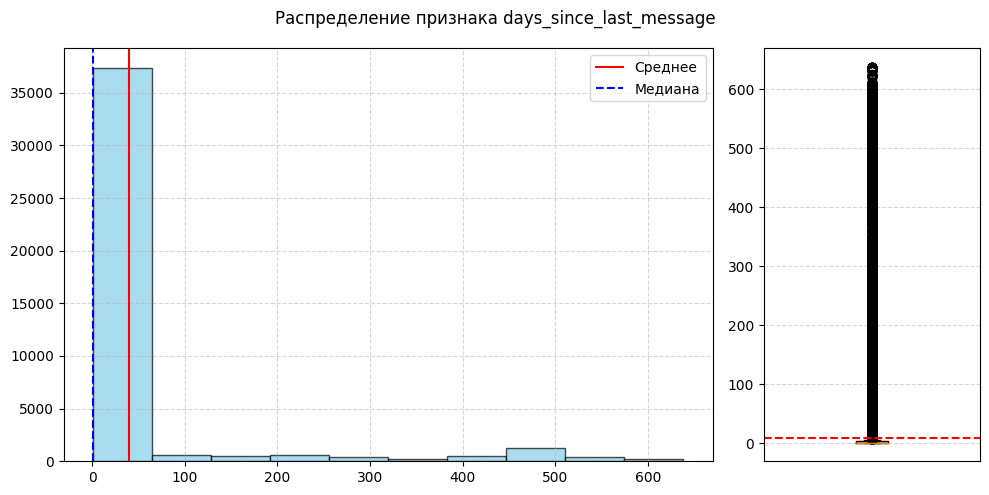

Описательные статистики для признака days_since_last_message:
count    41982.000
mean        39.542
std        117.679
min          1.000
25%          1.000
50%          1.000
75%          3.000
max        638.000
Name: days_since_last_message, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 963.0


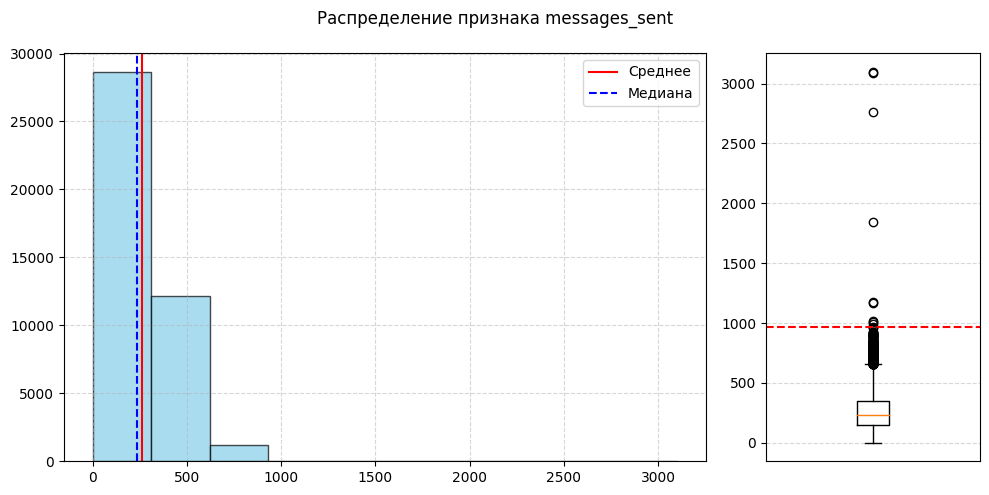

Описательные статистики для признака messages_sent:
count    41982.000
mean       260.848
std        160.084
min          1.000
25%        147.000
50%        233.000
75%        351.000
max       3100.000
Name: messages_sent, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 1827.0


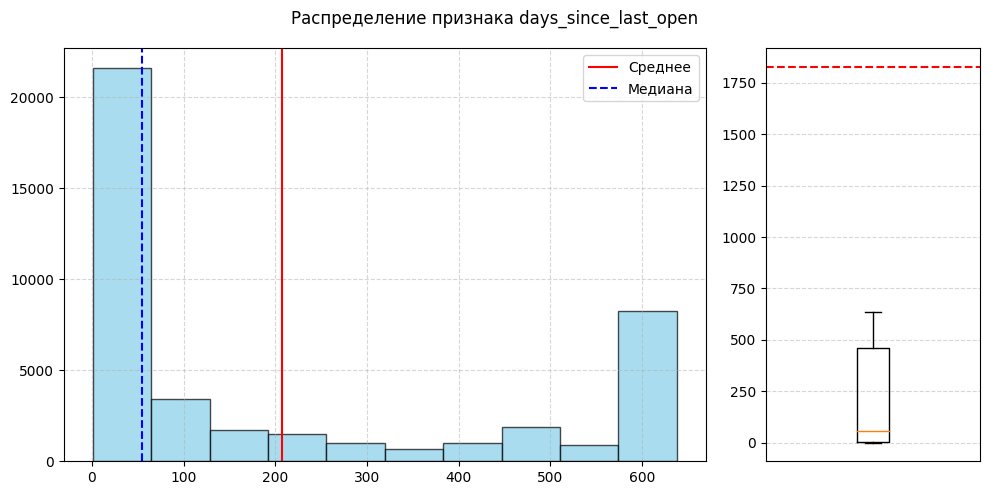

Описательные статистики для признака days_since_last_open:
count    41982.000
mean       207.777
std        252.788
min          1.000
25%          3.000
50%         55.000
75%        459.000
max        638.000
Name: days_since_last_open, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 1.202


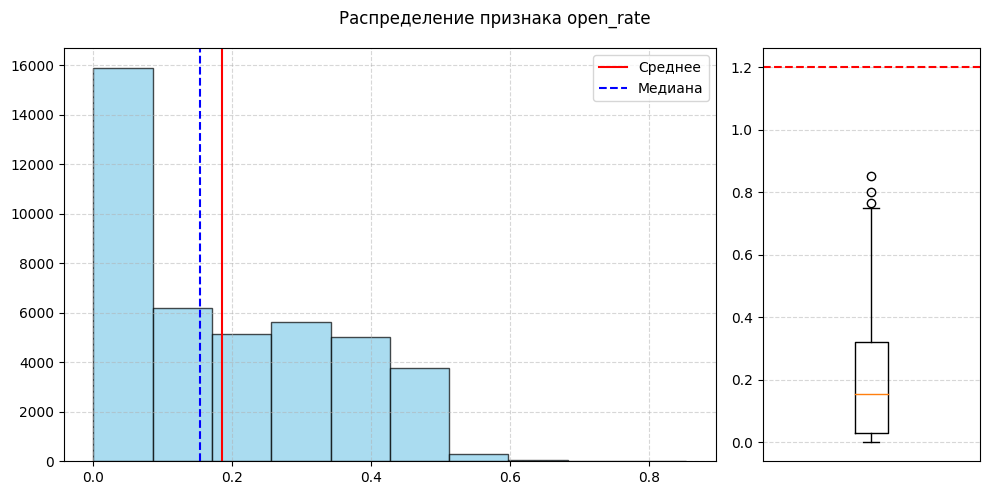

Описательные статистики для признака open_rate:
count    41982.000
mean         0.185
std          0.161
min          0.000
25%          0.029
50%          0.154
75%          0.322
max          0.854
Name: open_rate, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 0.222


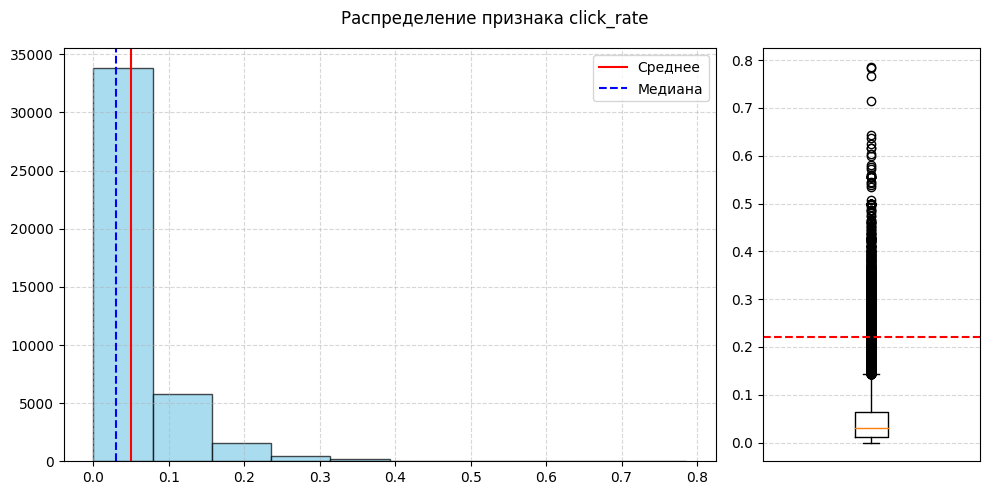

Описательные статистики для признака click_rate:
count    41982.000
mean         0.050
std          0.060
min          0.000
25%          0.013
50%          0.030
75%          0.065
max          0.786
Name: click_rate, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 0.026


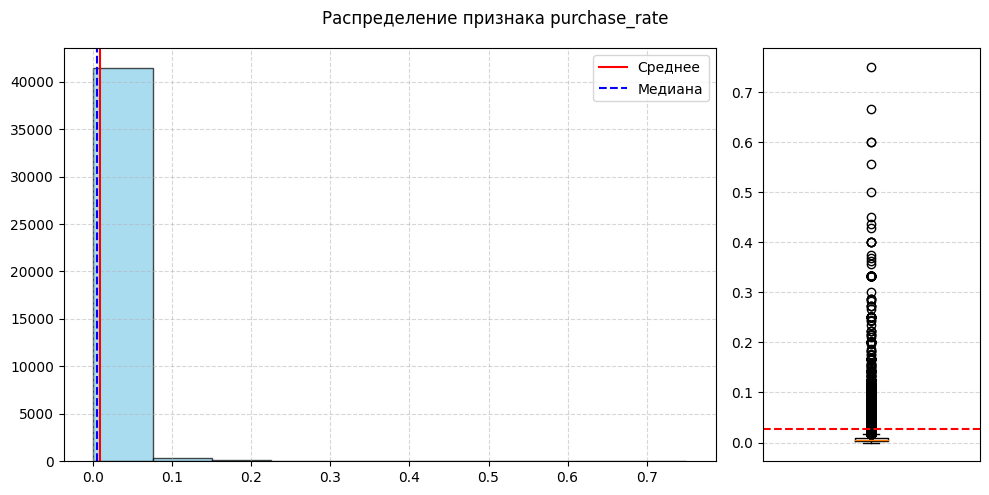

Описательные статистики для признака purchase_rate:
count    41982.000
mean         0.009
std          0.022
min          0.000
25%          0.003
50%          0.005
75%          0.009
max          0.750
Name: purchase_rate, dtype: float64
------------------------------------------------------------------------------------------
--- Границы выбросов: (0.0, 0.0)


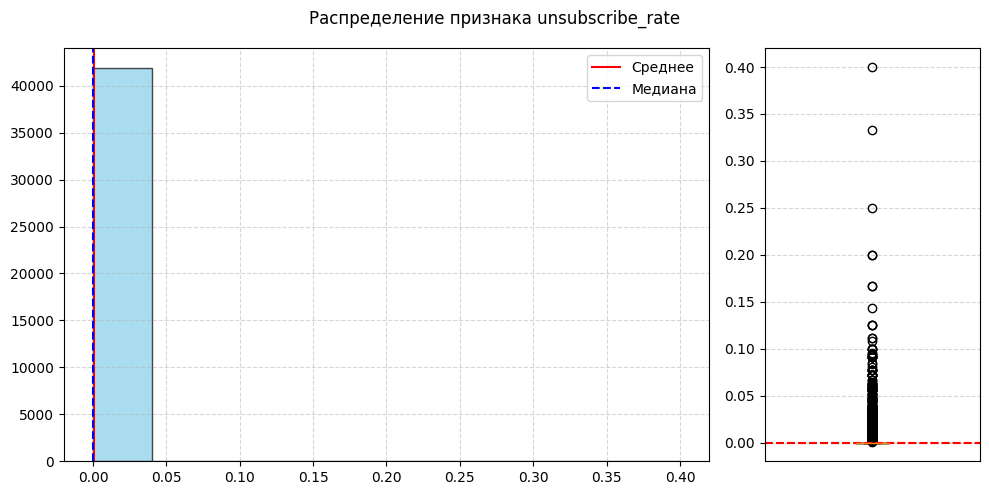

Описательные статистики для признака unsubscribe_rate:
count    41982.000
mean         0.001
std          0.005
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          0.400
Name: unsubscribe_rate, dtype: float64
------------------------------------------------------------------------------------------
--- Границы выбросов: (0.0, 0.0)


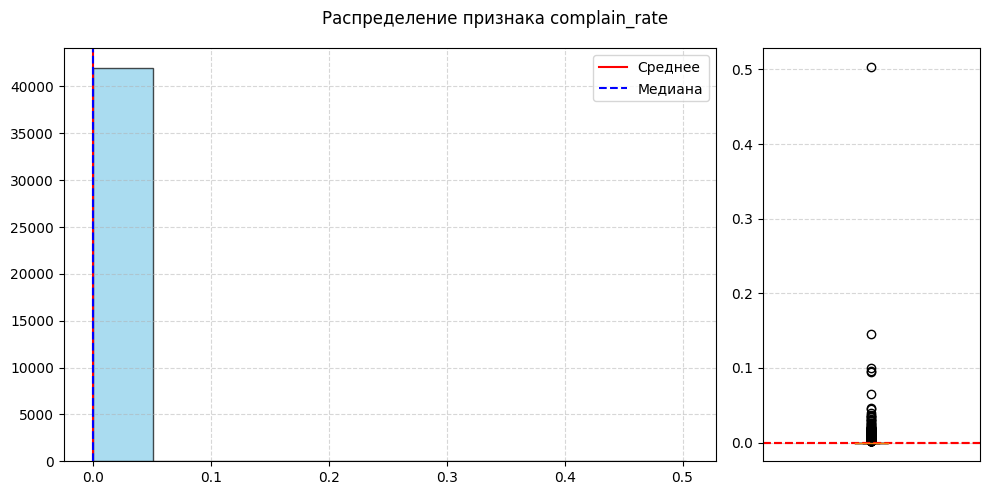

Описательные статистики для признака complain_rate:
count    41982.000
mean         0.000
std          0.003
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          0.503
Name: complain_rate, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 4.0


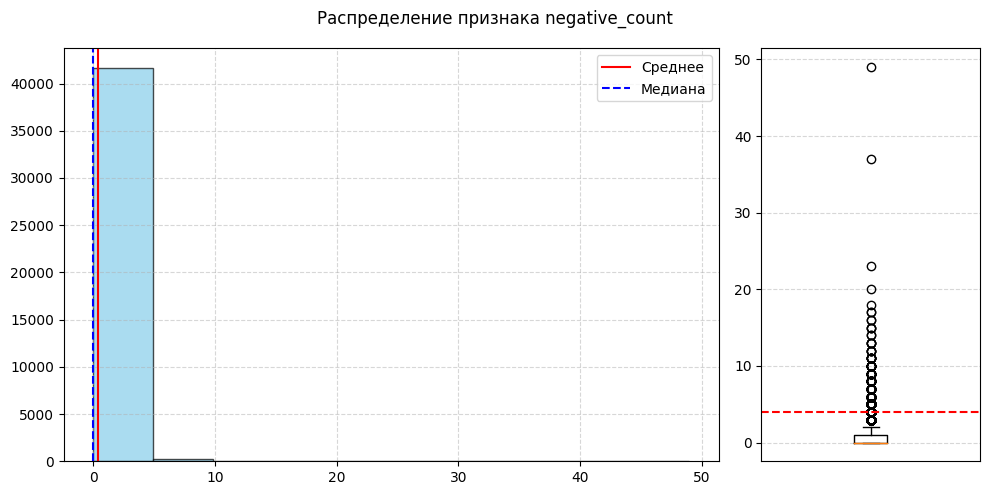

Описательные статистики для признака negative_count:
count    41982.000
mean         0.411
std          0.982
min          0.000
25%          0.000
50%          0.000
75%          1.000
max         49.000
Name: negative_count, dtype: float64
------------------------------------------------------------------------------------------


In [51]:
for col in [col for col in num_cols if col in messages_agg.columns]:
    graphs(marketing_agg.dropna(), col)

--- Граница выбросов 1470.0


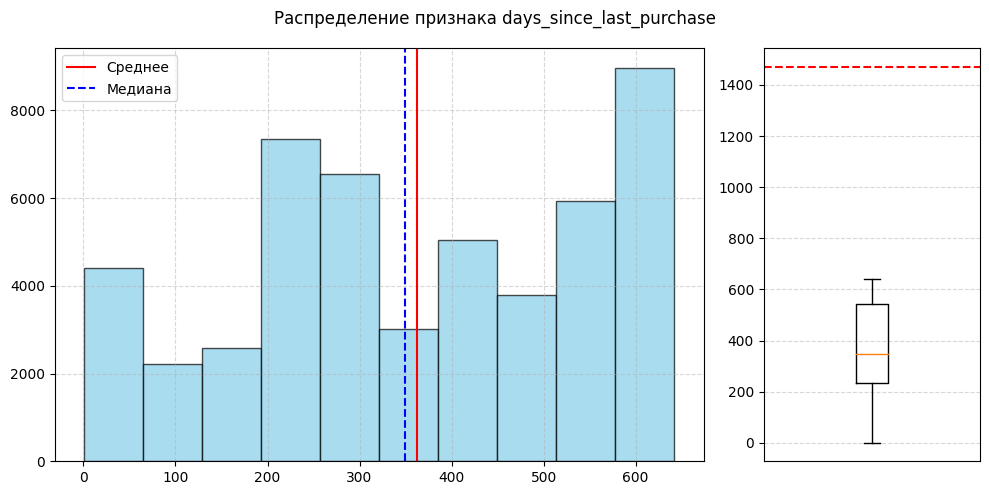

Описательные статистики для признака days_since_last_purchase:
count    49849.000
mean       362.932
std        185.302
min          1.000
25%        234.000
50%        349.000
75%        543.000
max        642.000
Name: days_since_last_purchase, dtype: float64
------------------------------------------------------------------------------------------


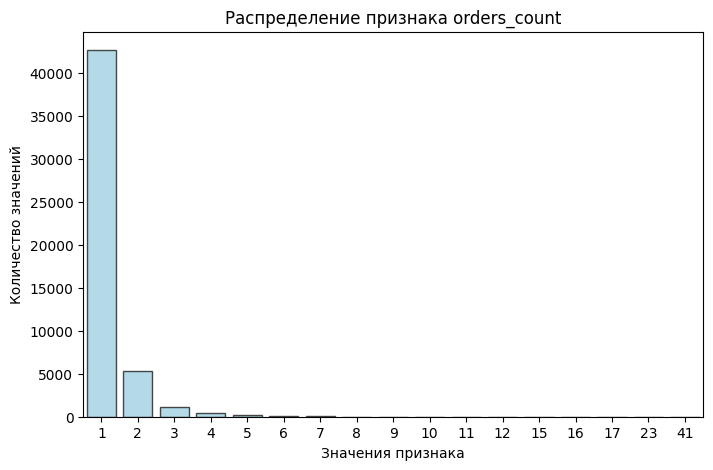

Описательные статистики для признака orders_count:
count    49849.000
mean         1.208
std          0.666
min          1.000
25%          1.000
50%          1.000
75%          1.000
max         41.000
Name: orders_count, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 18295.0


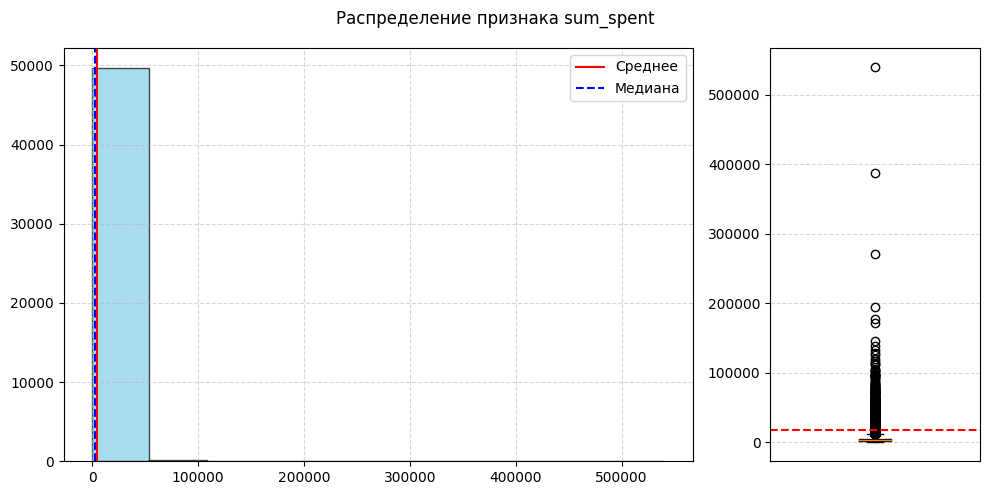

Описательные статистики для признака sum_spent:
count     49849.000
mean       4865.584
std        7351.467
min           1.000
25%        1499.000
50%        2969.000
75%        5698.000
max      540408.000
Name: sum_spent, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 5899.0


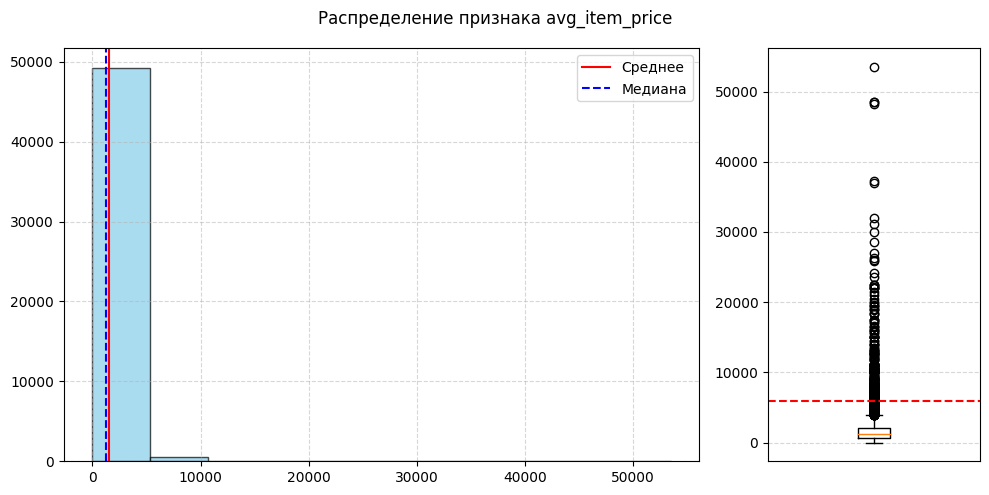

Описательные статистики для признака avg_item_price:
count    49849.000
mean      1483.415
std       1388.178
min          1.000
25%        699.000
50%       1249.000
75%       1999.000
max      53499.000
Name: avg_item_price, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 6066.0


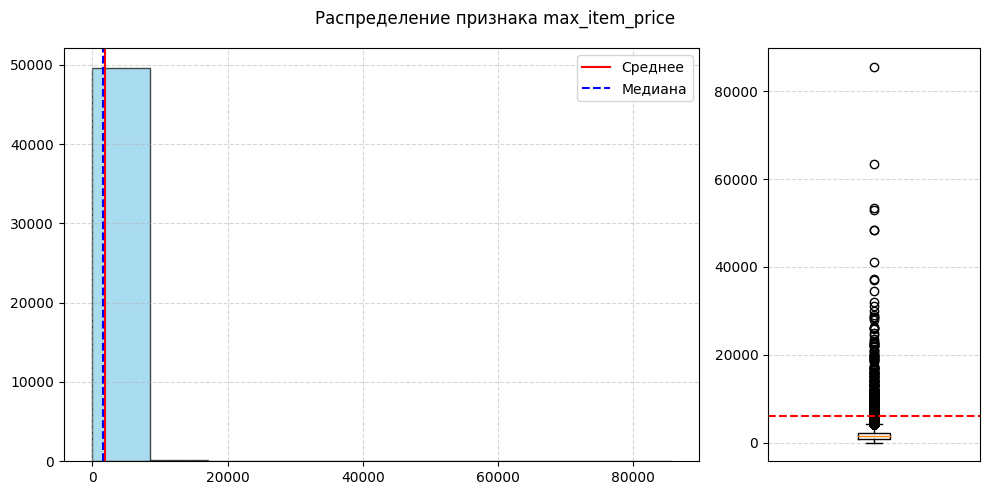

Описательные статистики для признака max_item_price:
count    49849.000
mean      1792.131
std       1647.321
min          1.000
25%        910.000
50%       1499.000
75%       2199.000
max      85499.000
Name: max_item_price, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 17.0


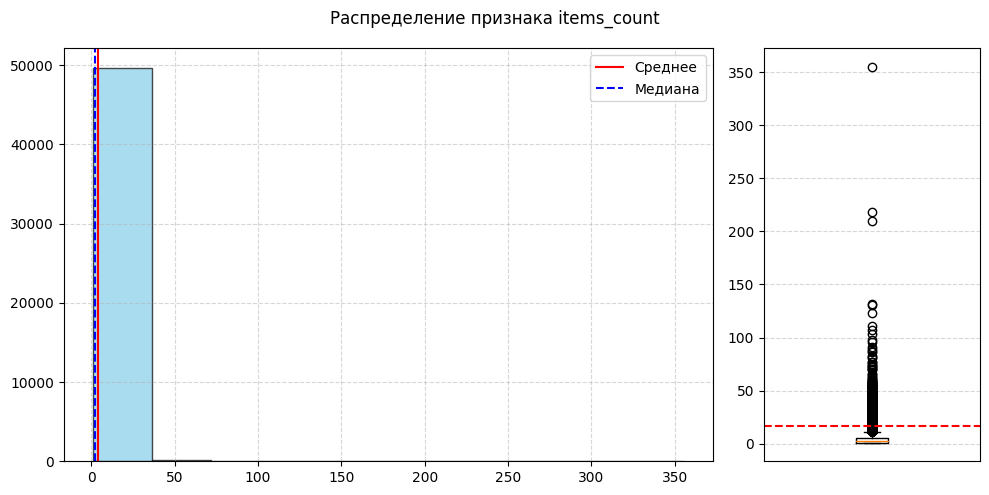

Описательные статистики для признака items_count:
count    49849.000
mean         4.083
std          5.563
min          1.000
25%          1.000
50%          2.000
75%          5.000
max        355.000
Name: items_count, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 15095.0


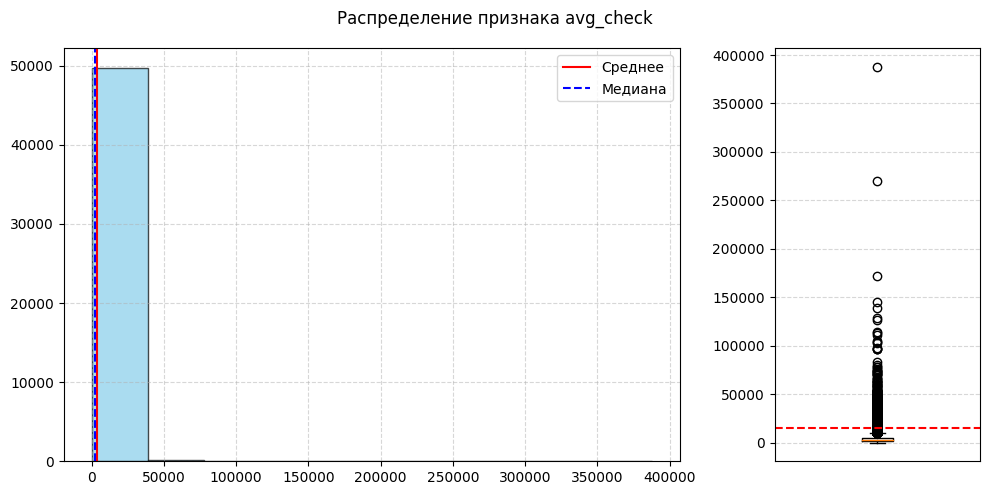

Описательные статистики для признака avg_check:
count     49849.000
mean       4043.237
std        5549.150
min           1.000
25%        1499.000
50%        2598.000
75%        4898.000
max      387583.000
Name: avg_check, dtype: float64
------------------------------------------------------------------------------------------
--- Граница выбросов 13.0


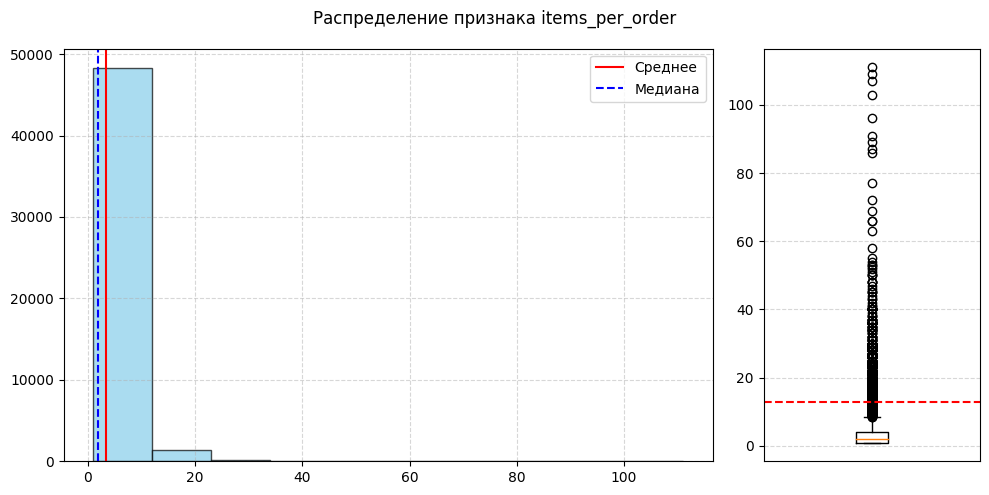

Описательные статистики для признака items_per_order:
count    49849.000
mean         3.333
std          3.780
min          1.000
25%          1.000
50%          2.000
75%          4.000
max        111.000
Name: items_per_order, dtype: float64
------------------------------------------------------------------------------------------


In [52]:
for col in [col for col in num_cols if col not in messages_agg.columns]:
    graphs(marketing_agg, col)

In [53]:
# функция для вывода круговой диаграммы 
def piechart(df, col):
    category_counts = df[col].value_counts()
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Круговая диаграмма для признака {col}')
    plt.text(-1.5, 1, f'Процент от {len(df)}', fontsize=9, color='black', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()
    print(90*'-')

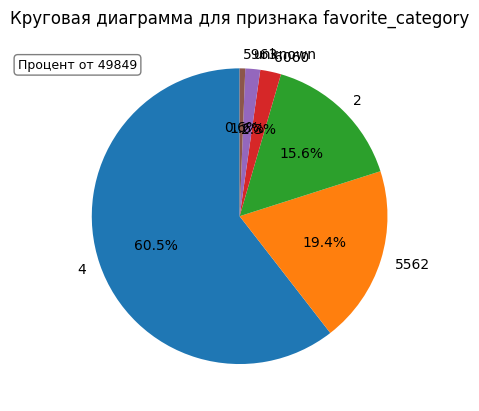

------------------------------------------------------------------------------------------


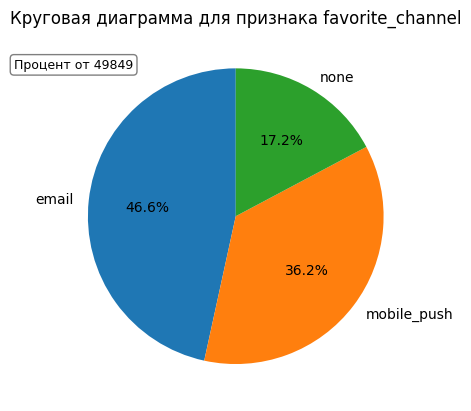

------------------------------------------------------------------------------------------


In [54]:
for col in cat_cols:
    piechart(marketing_agg, col)

### Распределение целевого признака

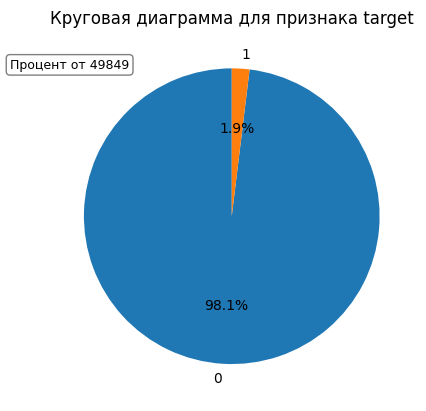

------------------------------------------------------------------------------------------


In [55]:
piechart(target_binary, 'target')

В целевом признаке сильный дисбаланс (преобладают те клиенты, которые не сделают покупки), это нужно будет учесть при разбиении на выборки.

### Матрица корреляций

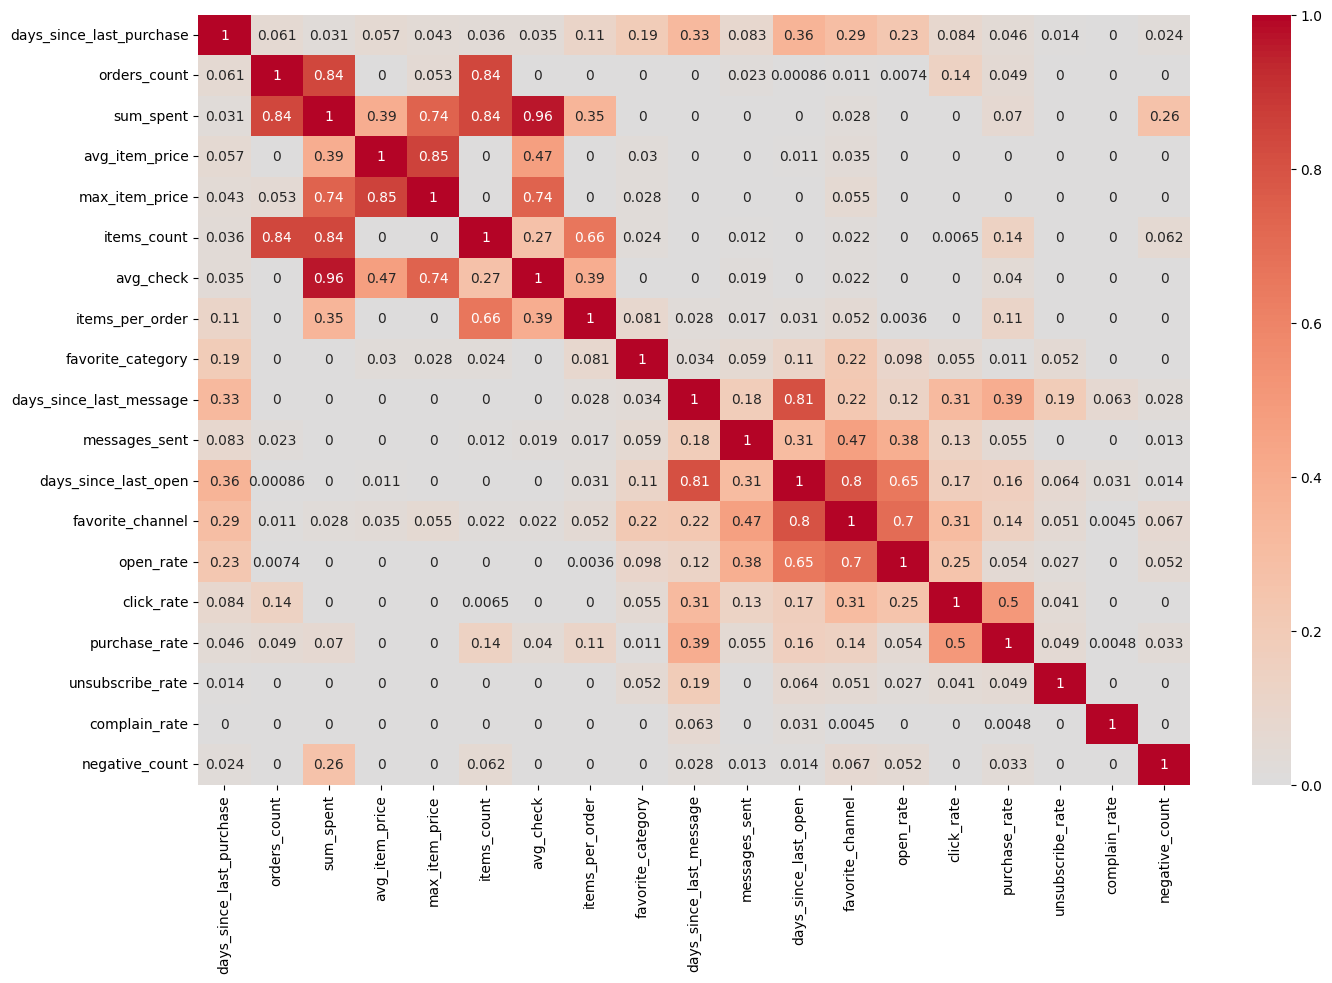

In [56]:
# матрица корреляций
plt.figure(figsize=(16,10))
sns.heatmap(marketing_agg.phik_matrix(interval_cols=num_cols),
            cmap='coolwarm', center=0, annot=True)
plt.show()

Обнаружилась сильная корреляция avg_check и sum_spent (0.96). Удалим признак sum_spent из рассмотрения.

In [57]:
marketing_agg = marketing_agg.drop('sum_spent', axis=1)
marketing_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_purchase  49849 non-null  int64  
 1   orders_count              49849 non-null  int64  
 2   avg_item_price            49849 non-null  float64
 3   max_item_price            49849 non-null  int64  
 4   items_count               49849 non-null  int64  
 5   avg_check                 49849 non-null  float64
 6   items_per_order           49849 non-null  float64
 7   favorite_category         49849 non-null  object 
 8   days_since_last_message   41982 non-null  float64
 9   messages_sent             41982 non-null  float64
 10  days_since_last_open      41982 non-null  float64
 11  favorite_channel          41982 non-null  object 
 12  open_rate                 41982 non-null  float64
 13  click_rate                419

Признак успешно удален.

## Моделирование

Создадим пайплайн, в котором подберем лучшие параметры для XGBoost. Эта модель была выбрана, поскольку она хорошо работает с табличными данными. Максимизировать будем метрику ROC-AUC.

In [58]:
num_cols = marketing_agg.select_dtypes(include='number').columns.tolist()
cat_cols = marketing_agg.select_dtypes(include='object').columns.tolist()

In [59]:
# обработка категориальных и числовых признаков
# OneHotEncoder для категориальных признаков
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [60]:
# пайплайн для количественных признаков
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

In [61]:
# общий пайплайн для подготовки данных
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
    ], 
    remainder='passthrough'
)

In [62]:
# итоговый пайплайн с моделью
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False,
                                 eval_metric='auc',
                                 random_state=RANDOM_STATE))
])

Убедимся, что в X и y будут одни и те же client_id:

In [63]:
set(marketing_agg.index) == (set(target_binary['client_id']))

True

Воспользуемся stratify, чтобы учесть дисбаланс классов:

In [64]:
# разбиение данных на выборки
X = marketing_agg[num_cols + cat_cols]
y = target_binary['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

In [65]:
# параметры для RandomizedSearch
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [3, 5, 7, 10]
}

In [66]:
# RandomizedSearch
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_grid, 
    n_iter=12, 
    scoring='roc_auc', 
    cv=5, 
    verbose=1, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\dasha\anaconda3\envs\practicum\lib\site-packages\xgboost\core.py:158: UserWarning: [05:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['days_since_last_purchase',
                                                                                'orders_count',
                                                                                'avg_item_price',
                                                                                'max_item_price',
                                                                                'items_count',
                                                                                'avg_check',
                                                                                'items_per_order',
                                                                                'days_sin...
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [3, 5, 7, 10],
                                        'classifier__n_estimators': [100, 300,
                                                                     500]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [67]:
# результаты RandomizedSearch
print(f"Лучшая метрика ROC-AUC на кросс-валидации: {random_search.best_score_:.3f}")
best_model = random_search.best_estimator_

Лучшая метрика ROC-AUC на кросс-валидации: 0.718


## Тестирование

In [68]:
# тестирование модели
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_metric = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC на тестовой выборке: {test_metric:.3f}")

ROC-AUC на тастовой выборке: 0.744


## Анализ важности признаков

In [69]:
# трансформация тестовых данных
preprocessor = best_model.named_steps['preprocessor']
x_test_transformed = preprocessor.transform(X_test)

In [70]:
# извлечение названий признаков
cat_transformer = preprocessor.named_transformers_['cat']
ohe_names = cat_transformer.named_steps['ohe'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_names)

In [71]:
# инициализация Explainer
classifier = best_model.named_steps['classifier']
explainer = shap.TreeExplainer(classifier)

In [72]:
# подсчет SHAP-значений
shap_values = explainer.shap_values(x_test_transformed)

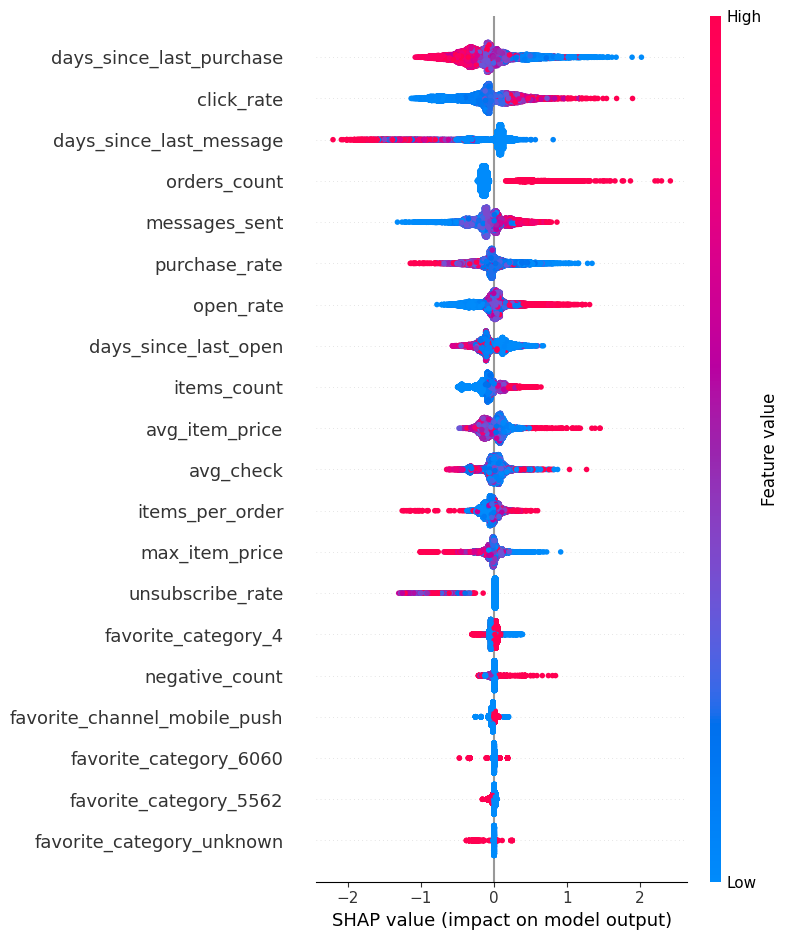

In [73]:
# график SHAP
shap.summary_plot(
    shap_values, 
    x_test_transformed, 
    feature_names=feature_names
)

Наиболее важными признаками оказались:
- days_since_last_purchase (чем меньше, тем выше вероятность покупки),
- click_rate (чем больше, тем выше вероятность покупки),
- days_since_last_message (чем больше, тем меньше вероятность покупки)
- orders_count (чем больше, тем выше вероятность покупки)

## Выводы

- Для получения полезных признаков необходимо было агрегировать таблицы purchases и messages по клиенту
- При этом обнаружилось, что для части клиентов нет данных о рассылках, хотя по косвенным признакам (наличие message_id в purchases) видно, что они были
- На полученном наборе признаков о покупательской активности и взаимодействии клиентов с рассылками была обучена модель XGBoost. Лучшие параметры были подобраны при помощи RandomizedSearch
- Модель не переобучилась и показала достаточно высокое качество
- Наиболее важными признаками оказались days_since_last_purchase (чем меньше, тем выше вероятность покупки), click_rate (чем больше, тем выше вероятность покупки), days_since_last_message (чем больше, тем меньше вероятность покупки) и orders_count (чем больше, тем выше вероятность покупки)